In [1]:
import numpy as np
import json
import csv
from collections import defaultdict
from operator import itemgetter
from typing import List, Dict, Tuple

import pandas as pd

In [2]:
with open('data/babel_label_CLIP_features_sim.npy', 'rb') as f:
    sim = np.load(f)
with open('data/proc_label_clustered.json', 'r') as f:
    proc_labels_parental_relationship:Dict[str,List[str]] = json.load(f)
    p2cs = proc_labels_parental_relationship
    c2p = dict(sum([[(child_label, parent_label) for child_label in child_labels] for parent_label, child_labels in proc_labels_parental_relationship.items()], []))
with open('data/babel_labelset.csv', 'r') as f:
    proc_labels_and_freqs:List[Tuple[str,int]] = [(proc_label, int(freq)) for proc_label, freq in list(csv.reader(f))]
proc_labels, freqs  = zip(*proc_labels_and_freqs)
p2f = proc2freq = dict(proc_labels_and_freqs)
l2i = proc_label_to_index = {proc_label: i for i, (proc_label, _) in enumerate(proc_labels_and_freqs)}
i2l = [proc_label for proc_label, _ in proc_labels_and_freqs]

selected_indices = sum([[l2i[child_label] for child_label in child_labels] for child_labels in proc_labels_parental_relationship.values()], [])
selected_mask = np.in1d(np.arange(sim.shape[0]), selected_indices)
not_selected_mask = ~selected_mask
not_selected_indices, = np.where(not_selected_mask)

# 알고리즘

## 목적
- 4611개의 label 중 selected label은 60개밖에 안 됨
- 60개의 label에 대한 sample들을 Kinetics400에 mapping 해본 결과 known sample 수가 1000개 정도밖에 안 됨
- Label들을 look-up 해본 결과 비슷한 label들이 매우 많음
  - 오타들도 굉장히 많음
- CLIP을 통해 힌트를 얻어 비슷한 label들을 합치기 위함
  - CLIP은 오타에 robust함

## Constraints
- Samples 수가 100개보다 적은 parent-label 수를 최대한 적게
- Similarity가 낮은 selected label 수를 최대한 적게
- Selected label은 중복이 없어야 함

## 상세

### Given
- child-label = 최초에 select 된 **proc_label**
- 각 **proc_label**에 해당하는 sample 수

### Pseudo-code
1. `until` 모든 parent-label이 추가로 획득한 sample 수가 `100`을 넘거나 `thres`가 `min_thres`에 도달할 때까지
2. &emsp;아직 *additionally-selected* 되지 않은 **proc_label** 중, 대응되는 parent-label의 sample 수가 아직 `100`을 넘지 않은 child-label들에 대한 simliarity를 계산하여 이의 최댓값이 `thres` 범위 안에 들어가는 **proc_label**들을 *additionally-selected label*로 선정
3. &emsp;Additionally-selected **proc_label**들을 각각의 simliarity 최댓값에 대응되는 child-label에 할당

In [3]:
eps = 1e-6
thres0 = 90.
thres_diff = 1.
thres_min = 80.
LabelFreqScore = Tuple[str,int,float]
Matched2Child = Dict[str,LabelFreqScore]
matched2child:Matched2Child = {}  # matched_label -> score, child_label

def make_correspondences_from_matched2child(matched2child:Matched2Child, sort_by_score=False) -> Dict[str,Dict[str,List[LabelFreqScore]]]:
    correspondences = defaultdict(lambda: defaultdict(list))  # parent_label -> child_label -> matched_label, freq, score
    # insert
    for matched_label, (child_label, freq, score) in matched2child.items():
        parent_label = c2p[child_label]
        correspondences[parent_label][child_label].append((matched_label, freq, score))
    # sort by score
    if sort_by_score:
        for parent_label in correspondences:
            for child_label in correspondences[parent_label]:
                matched_list = correspondences[parent_label][child_label]
                correspondences[parent_label][child_label] = sorted(matched_list, key=itemgetter(2), reverse=True)
    return correspondences

thres = thres0
sim_df = pd.DataFrame(sim, index=proc_labels, columns=proc_labels)
sim_df = sim_df.iloc[not_selected_mask,selected_mask]
prev_additionally_selected_mask = np.zeros(sim_df.shape[0], dtype=bool)
done_child_mask = np.zeros(sim_df.shape[1], dtype=bool)
while True:
    sim_df = sim_df.iloc[~prev_additionally_selected_mask, ~done_child_mask]
    sim_max = sim_df.max(axis=1)
    new_additional_selected_mask = (thres <= sim_max) & (sim_max < (thres+1 if thres<90-eps else 100))
    newly_matched2child:Dict[str,str] = sim_df.loc[new_additional_selected_mask].idxmax(axis=1).to_dict()
    newly_matched2child:Matched2Child = {matched: (child, p2f[matched], sim_max[matched].astype(float)) for matched, child in newly_matched2child.items()}
    matched2child.update(newly_matched2child)
    correspondences = make_correspondences_from_matched2child(matched2child)
    current_parent_freqs = pd.Series({
        parent_label: sum(
            freq
            for matched_labels in child_label_dict.values()
            for matched_label, freq, score in matched_labels
        )
        for parent_label, child_label_dict in correspondences.items()
    }, index=correspondences.keys())
    done_child_mask = np.array(
        [current_parent_freqs.get(c2p[remaining_child_label], 0) >= 100  # parent_label not in current_parent_freqs? haven't been selected yet
         for remaining_child_label in sim_df.columns], dtype=bool)
    if done_child_mask.all() or abs(thres-thres_min) < 1e-3:
        break
    else:
        print(f'[{current_parent_freqs.sum()} samples]  [{new_additional_selected_mask.sum():4d} / {new_additional_selected_mask.shape[0]} / 4611]  [selected / left / total]')
        prev_additionally_selected_mask = new_additional_selected_mask.to_numpy()
        thres -= thres_diff

correspondences = make_correspondences_from_matched2child(matched2child, True)
with open('data/babel_label_CLIP_matches.json', 'w') as f:
    string = json.dumps(correspondences, indent=2)
    string = (
        string
        .replace('[\n        ', '[')
        .replace(',\n        ', ', ')
        .replace('\n      ]', ']')) 
    f.write(string)

[7563 samples]  [2117 / 4551 / 4611]  [selected / left / total]
[7669 samples]  [  44 / 2434 / 4611]  [selected / left / total]
[7834 samples]  [  54 / 2390 / 4611]  [selected / left / total]
[7903 samples]  [  34 / 2336 / 4611]  [selected / left / total]
[7978 samples]  [  41 / 2302 / 4611]  [selected / left / total]
[7978 samples]  [   0 / 2261 / 4611]  [selected / left / total]
[7980 samples]  [   1 / 2261 / 4611]  [selected / left / total]
[7985 samples]  [   1 / 2260 / 4611]  [selected / left / total]
[7988 samples]  [   2 / 2259 / 4611]  [selected / left / total]
[7988 samples]  [   0 / 2257 / 4611]  [selected / left / total]


In [4]:
freqs_parent_after = {
    'bend': 233, 'catch': 184, 'clap': 91, 'clean': 116, 'crawl': 64, 'dance': 163, 'jump': 347, 'kick': 286, 'pick up': 515,
    'place': 233, 'punch': 80, 'run': 618, 'sit down': 451, 'squat': 117, 'stand up': 305, 'step': 672, 'throw': 333, 'turn': 1572, 'walk': 3633, 'wave': 163
}

In [10]:
known_labels = ['jump', 'run', 'throw', 'kick', 'dance', 'clap', 'crawl', 'squat', 'punch', 'bend', 'clean', 'pick up']
unknown_labels = ['walk', 'catch', 'stand up', 'sit down', 'turn', 'step', 'wave', 'place']

FreqTuplesParent = List[Tuple[str,int]]
FreqTuples = List[Tuple[str,int,FreqTuplesParent]]

def printer(freq_tuples:FreqTuples):
    label_width = 40
    indent = 4
    divider = '-' * (label_width + indent) + '\n'
    parent_blocks = []
    for parent_label, freq_parent, freq_tuples_parent in freq_tuples:
        parent_block = f'{parent_label:{label_width}}{freq_parent:4d}\n\n'
        for child_label, freq_child in freq_tuples_parent:
            parent_block += ' '*indent + f'{child_label:{label_width-indent}}{freq_child:4d}\n'
        parent_blocks.append(parent_block)
    print(divider.join(parent_blocks))

additional_freq_tuples:FreqTuples = []
for parent_label, child_label_dict in correspondences.items():
    freq_parent = 0
    additional_freq_tuples_parent:FreqTuplesParent = []
    for child_label, matched_labels in child_label_dict.items():
        freq_child = sum(freq for _, freq, _ in matched_labels)
        additional_freq_tuples_parent.append((child_label, freq_child))
        freq_parent += freq_child
    additional_freq_tuples_parent = sorted(additional_freq_tuples_parent, key=itemgetter(1), reverse=True)
    additional_freq_tuples.append((parent_label, freq_parent, additional_freq_tuples_parent))
additional_freq_tuples = sorted(additional_freq_tuples, key=lambda args: 100000 * (args[0] in known_labels) + freqs_parent_after[args[0]], reverse=True)
addtional_known_freq_tuples, addtional_unknown_freq_tuples = additional_freq_tuples[:len(known_labels)], additional_freq_tuples[len(known_labels):]

print(f'{" known ":=^44s}\n')
printer(addtional_known_freq_tuples)
print(f'\n{" unknown ":=^44s}\n')
printer(addtional_unknown_freq_tuples)

================== known ===================

run                                      280

    run forward                          136
    run in place                          92
    run                                   41
    jog                                   11
--------------------------------------------
pick up                                  557

    pick something up with right hand    329
    pick up object                       110
    pick up                               48
    lift                                  34
    lift object                           23
    pick up object from ground            13
--------------------------------------------
jump                                     176

    jump                                 116
    jump forward                          60
--------------------------------------------
throw                                    109

    throw                                 68
    throw a ball                          33
    t

# 그래프

In [6]:
import matplotlib.pyplot as plt

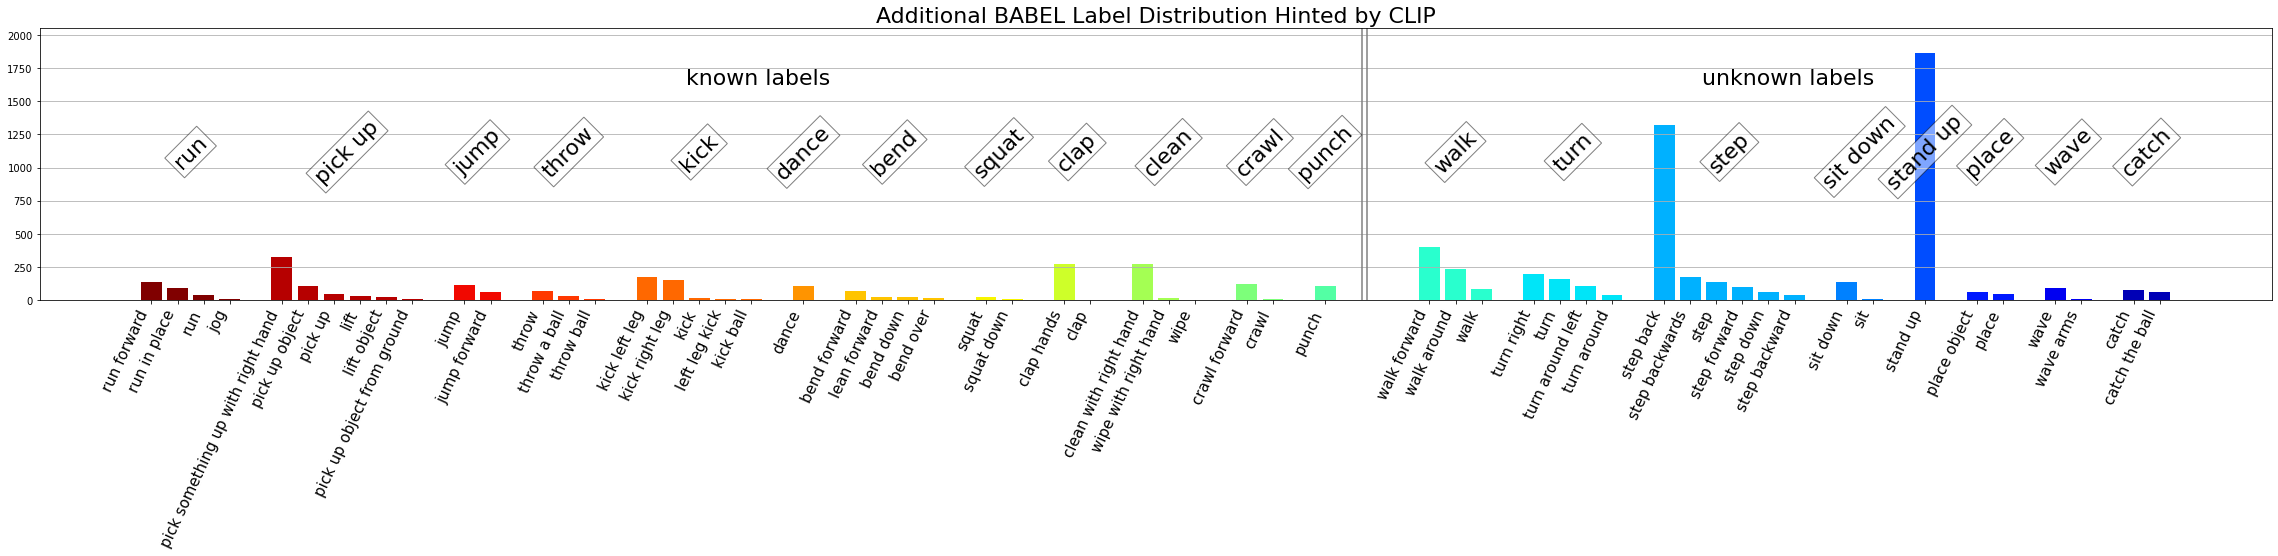

In [7]:
pointer = 0
xticks = []
jet = plt.get_cmap('jet')
plt.figure(figsize=(40, 5))
plt.title('Additional BABEL Label Distribution Hinted by CLIP', fontsize=22)

def draw_text(x, y, text, rotation=0):
    t = plt.text(
        x, y, text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=22, rotation=rotation)
    return t

def draw_bars(xticks, y, freqs, color, label:str):
    plt.bar(xticks, freqs, color=color)
    t = draw_text(xticks.mean(), y, label, 45)
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='black'))

all_child_labels_sorted = []
freq_max = max([max(list(zip(*freq_tuples_parent))[1]) for _, _, freq_tuples_parent in additional_freq_tuples])
for i, (parent_label, freq_parent, freq_tuples_parent) in enumerate(additional_freq_tuples):
    # get vars
    child_labels, freqs_child = zip(*freq_tuples_parent)
    curr_xticks = np.arange(len(freq_tuples_parent)) + pointer
    # draw
    draw_bars(curr_xticks, freq_max*.6, freqs_child, jet(1-i/len(additional_freq_tuples)), parent_label)
    if i == len(known_labels) - 1:
        x = curr_xticks[-1] + 1.5
        plt.plot(
            [x-.1, x-.1], [0, freq_max*1.1],
            [x+.1, x+.1], [0, freq_max*1.1], color='gray')
        pointer += 2
    # update
    xticks += curr_xticks.tolist()
    pointer += len(child_labels) + 1
    all_child_labels_sorted += child_labels

draw_text(x/2, freq_max*.9, 'known labels')
draw_text(x/2+pointer/2, freq_max*.9, 'unknown labels')
plt.gca().set_xticks(xticks, all_child_labels_sorted, rotation=65, fontsize=15, ha='right')
plt.ylim(0, freq_max*1.1)
plt.grid(axis='y')
plt.show()

In [8]:
# https://stackoverflow.com/a/55501861
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase

class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent], 
                          width / self.num_stripes, 
                          height, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

run        618
pick up    515
jump       347
throw      333
kick       286
bend       233
dance      163
squat      117
clean      116
clap       91
punch      80
crawl      64
walk       3633
turn       1572
step       672
sit down   451
stand up   305
place      233
catch      184
wave       163


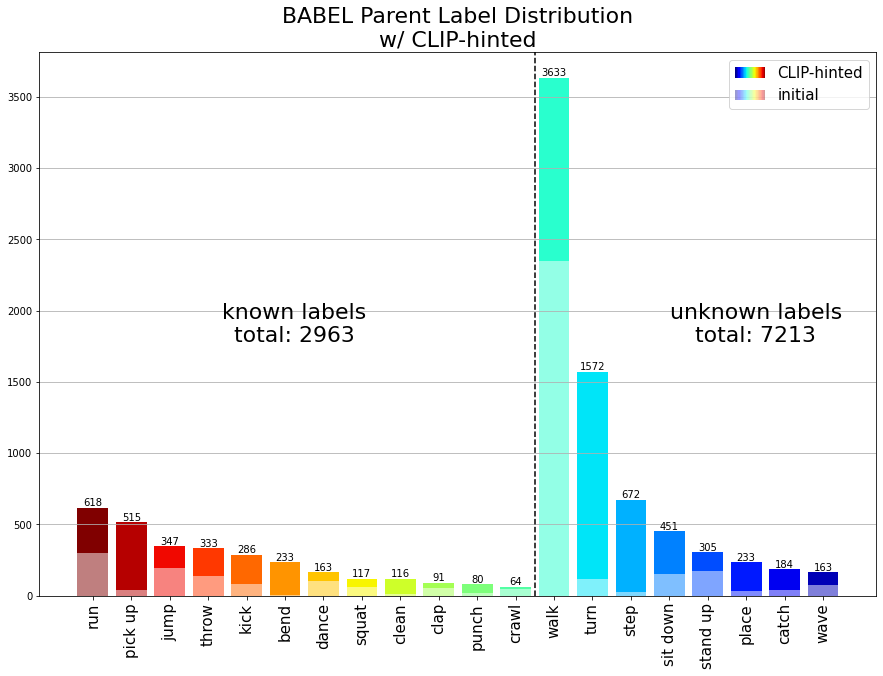

In [17]:
plt.figure(figsize=(15, 10))
plt.title('BABEL Parent Label Distribution\nw/ CLIP-hinted', fontsize=22)
all_parent_labels_sorted, freqs_parent, _ = zip(*additional_freq_tuples)

max_freq_parent = 0
total_known, total_unknown = 0, 0
for i, parent_label in enumerate(all_parent_labels_sorted):
    freq_parent = freqs_parent_after[parent_label]
    color = jet(1 - i/len(additional_freq_tuples))
    bottom = p2f[parent_label]
    plt.bar([i], bottom, color=(*color[:3], .5))
    plt.bar([i], freq_parent-bottom, color=color, bottom=bottom)
    plt.text(i, freq_parent, f'{freq_parent}', ha='center', va='bottom')
    max_freq_parent = max(max_freq_parent, freq_parent)
    print(f'{parent_label:10} {freq_parent}')
    if i < len(known_labels):
        total_known += freq_parent
    else:
        total_unknown += freq_parent
x = len(known_labels) - .5
y = max_freq_parent * 1.05
plt.plot([x, x], [0, y], '--', color='k')
plt.ylim(0, y)
draw_text(x/2-.5, y*.5, f'known labels\ntotal: {total_known}')
draw_text(x/2+len(freqs_parent)/2+1.5, y*.5, f'unknown labels\ntotal: {total_unknown}')
plt.gca().set_xticks(np.arange(len(additional_freq_tuples)), all_parent_labels_sorted, rotation=90, fontsize=15)

cmap_handles = [plt.Rectangle((0,0),1,1) for _ in range(2)]
handler_map = dict(zip(cmap_handles, [HandlerColormap(cm, num_stripes=50) for cm in (jet, lambda x: (*jet(x)[:3], .4))]))
plt.legend(
    handles=cmap_handles,
    labels=['CLIP-hinted', 'initial'],
    handler_map=handler_map,
    fontsize=15)
plt.grid(axis='y')
plt.show()

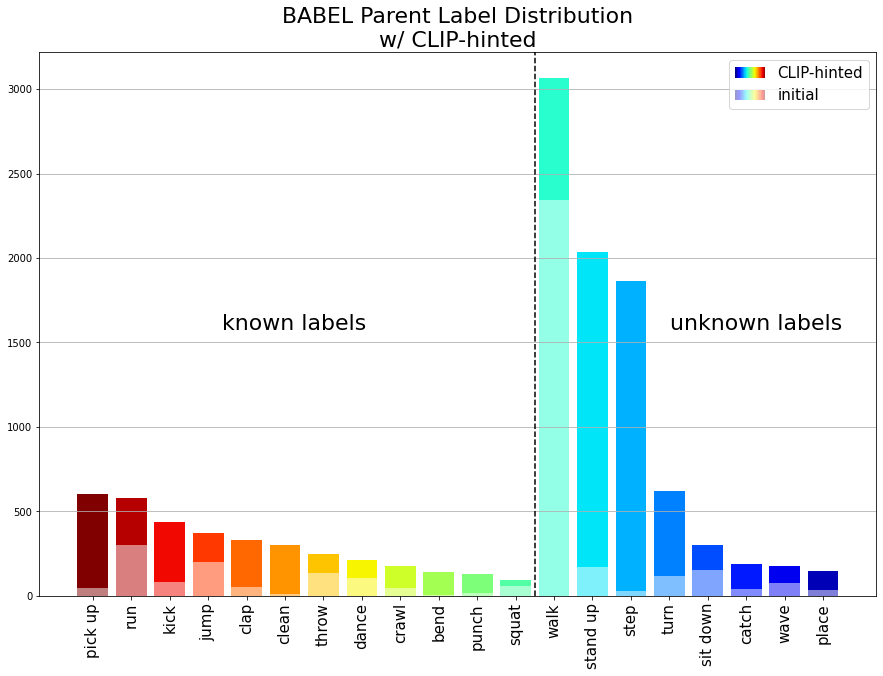

In [14]:
plt.figure(figsize=(15, 10))
plt.title('BABEL Parent Label Distribution\nw/ CLIP-hinted', fontsize=22)
all_parent_labels_sorted, freqs_parent, _ = zip(*additional_freq_tuples)

max_freq_parent = 0
for i, (parent_label, freq_parent) in enumerate(zip(all_parent_labels_sorted, freqs_parent)):
    color = jet(1 - i/len(additional_freq_tuples))
    bottom = p2f[parent_label]
    plt.bar([i], bottom, color=(*color[:3], .5))
    plt.bar([i], freq_parent, color=color, bottom=bottom)
    max_freq_parent = max(max_freq_parent, bottom+freq_parent)
x = len(known_labels) - .5
y = max_freq_parent * 1.05
plt.plot([x, x], [0, y], '--', color='k')
plt.ylim(0, y)
draw_text(x/2-.5, y*.5, 'known labels')
draw_text(x/2+len(freqs_parent)/2+1.5, y*.5, 'unknown labels')
plt.gca().set_xticks(np.arange(len(additional_freq_tuples)), all_parent_labels_sorted, rotation=90, fontsize=15)

cmap_handles = [plt.Rectangle((0,0),1,1) for _ in range(2)]
handler_map = dict(zip(cmap_handles, [HandlerColormap(cm, num_stripes=50) for cm in (jet, lambda x: (*jet(x)[:3], .4))]))
plt.legend(
    handles=cmap_handles,
    labels=['CLIP-hinted', 'initial'],
    handler_map=handler_map,
    fontsize=15)
plt.grid(axis='y')
plt.show()

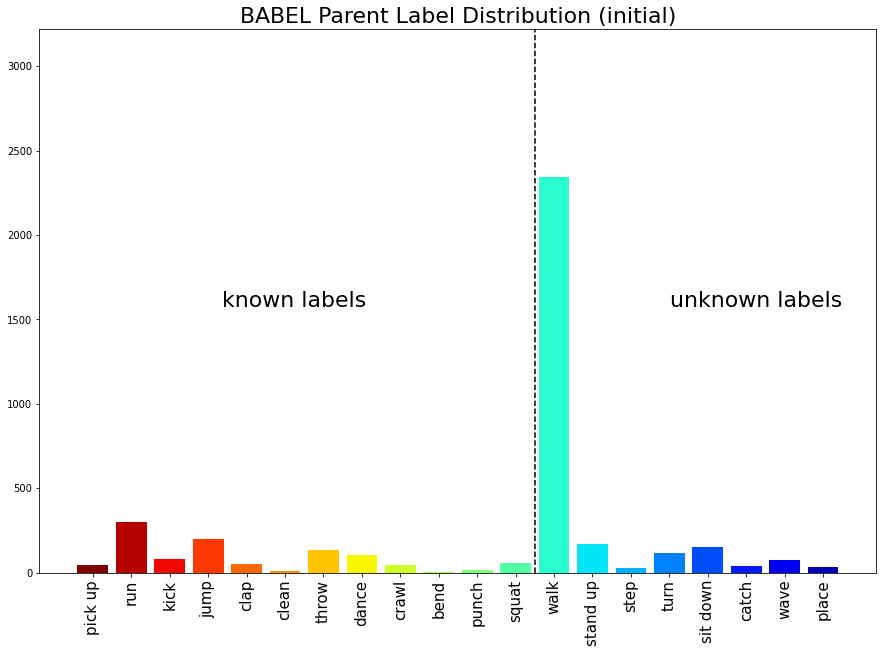

In [269]:
plt.figure(figsize=(15, 10))
plt.title('BABEL Parent Label Distribution (initial)', fontsize=22)

freqs_parent_initial = [p2f[parent_label] for parent_label in all_parent_labels_sorted]
for i, freq in enumerate(freqs_parent_initial):
    color = jet(1 - i/len(all_parent_labels_sorted))
    plt.bar([i], freq, color=color)
x = len(known_labels) - .5
y = max_freq_parent * 1.05
plt.plot([x, x], [0, y], '--', color='k')
plt.ylim(0, y)
draw_text(x/2-.5, y*.5, 'known labels')
draw_text(x/2+len(freqs_parent)/2+1.5, y*.5, 'unknown labels')
plt.gca().set_xticks(np.arange(len(additional_freq_tuples)), all_parent_labels_sorted, rotation=90, fontsize=15)
plt.show()

# 이 밑은 시행착오

In [15]:
thres = 90.
Matched2Child = Dict[str,Tuple[str,int,float]]
matched2child:Matched2Child = {}  # matched_label -> score, child_label
selected_indices = sum([[l2i[child_label] for child_label in child_labels] for child_labels in proc_labels_parental_relationship.values()], [])

selected_mask = np.in1d(np.arange(sim.shape[0]), selected_indices)
not_selected_mask = ~selected_mask
not_selected_indices, = np.where(not_selected_mask)
masked_sim = sim[:,selected_mask]

sim_mask = not_selected_mask.reshape(-1,1) * selected_mask.reshape(1,-1)
masked_sim = np.ma.MaskedArray(sim, ~sim_mask)
sorting_args = masked_sim.argsort(axis=1, fill_value=-1)[:,::-1]  # [4611, 4611]
sorted_sim = np.take_along_axis(masked_sim, sorting_args, axis=1)
is_assigned = selected_mask.copy()

i = 0
while True:
    # 할당
    to_be_assigned_mask = ~is_assigned & (sorted_sim[:,i] >= 90.)
    to_be_assigned_child_labels = np.take(proc_labels, sorting_args[:,i]) # 90% 넘는 애들의 label을 받아와야 함
    # 검사
    break

array(['cross hands', 'stand up', 'clap hands', ..., 'step back',
       'step back', 'clap hands'], dtype='<U119')

In [ ]:
selected_mask_after_processed = not_selected_mask.copy()
matched_selected_indices = masked_sim.argmax(axis=1, fill_value=-1)  # [4611]
for i, (matched_selected_index, not_selected_mask) in enumerate(zip(matched_selected_indices, not_selected_mask)):
    if not not_selected_mask:
        continue
    child_label = i2l[matched_selected_index]
    matched_label, freq = proc_labels_and_freqs[i]
    freq = int(freq)
    score = sim[i,matched_selected_index].astype(float)
    if score > thres:
        matched2child[matched_label] = (child_label, freq, score)
        selected_mask_after_processed[i] = True  # 남아도는 label에 붙어있는 애들 중 score가 모자라서 잘린 애들은 다른 label에 붙을 기회를 줘야 함

correspondences = defaultdict(lambda: defaultdict(list))  # parent_label -> child_label -> matched_label, score
for matched_label, (child_label, freq, score) in matched2child.items():
    parent_label = c2p[child_label]
    correspondences[parent_label][child_label].append((matched_label, freq, score))
for parent_label in correspondences:
    for child_label in correspondences[parent_label]:
        matched_list = correspondences[parent_label][child_label]
        correspondences[parent_label][child_label] = sorted(matched_list, key=itemgetter(2), reverse=True)

with open('data/babel_label_CLIP_matches.json', 'w') as f:
    string = json.dumps(correspondences, indent=2)
    string = (
        string
        .replace('[\n        ', '[')
        .replace(',\n        ', ', ')
        .replace('\n      ]', ']')) 
    f.write(string)

In [ ]:
thres0 = 90.
thres_diff = 1.
Matched2Child = Dict[str,Tuple[str,int,float]]
matched2child:Matched2Child = {}  # matched_label -> score, child_label
selected_indices = sum([[l2i[child_label] for child_label in child_labels] for child_labels in proc_labels_parental_relationship.values()], [])
total_freqs = 0
for parent_label, child_labels in proc_labels_parental_relationship.items():
    thres = thres0
    print(parent_label)
    while True:
        freq_parent = 0
        matched2child_tmp:Matched2Child = {}
        for child_label in child_labels:
            sim_arr = sim[l2i[child_label]]
            args = sim_arr.argsort()[::-1]
            cousin_mask = np.in1d(args, selected_indices)
            matched_args = args[(sim_arr[args]>thres) & ~cousin_mask]  # >90% and not other cousin labels
            for arg in matched_args:
                freq = int(proc_labels_and_freqs[arg][1])
                matched_label = i2l[arg]
                score = sim_arr[arg].astype(float)  # convert to built-in float to serialize
                if matched_label in matched2child:
                    if score < matched2child[matched_label][2]:  # when duplicated, drop the less-score one
                        continue
                freq_parent += freq
                matched2child_tmp[matched_label] = (child_label, freq, score)
        print('\t', freq_parent, thres)
        if freq_parent > 100:
            print(json.dumps(matched2child_tmp, indent=2))
            matched2child.update(matched2child_tmp)  # 아 미친 다른 애한테 뺏기네
            break
        thres -= thres_diff
    total_freqs += freq_parent
print(total_freqs)

correspondences = defaultdict(lambda: defaultdict(list))  # parent_label -> child_label -> matched_label, score
for matched_label, (child_label, freq, score) in matched2child.items():
    parent_label = c2p[child_label]
    correspondences[parent_label][child_label].append((matched_label, freq, score))
for parent_label in correspondences:
    for child_label in correspondences[parent_label]:
        matched_list = correspondences[parent_label][child_label]
        correspondences[parent_label][child_label] = sorted(matched_list, key=itemgetter(2), reverse=True)

with open('data/babel_label_CLIP_matches.json', 'w') as f:
    string = json.dumps(correspondences, indent=2)
    string = (
        string
        .replace('[\n        ', '[')
        .replace(',\n        ', ', ')
        .replace('\n      ]', ']')) 
    f.write(string)